In [ ]:
import torch
from torchvision.models import vgg16, VGG16_Weights, inception_v3, Inception_V3_Weights
import torch.nn as nn
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    Resize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
)
from torchvision.datasets import ImageFolder

import pandas as pd

from classification_model import ClassificationModelBuilding
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim as optim
from torchvision.transforms import functional as TF

import os
import fnmatch
import random
import copy

from torch.optim.lr_scheduler import ReduceLROnPlateau
from Focal_Loss import FocalLoss

import matplotlib.pyplot as plt

### Data Preprocessing

In [2]:
# Rotate images at pre-defined angles
class RandomRotation:
    def __init__(self, angles=[90, 180, 270]):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return TF.rotate(img, angle)

In [ ]:
train_root_dir = "../data/skin_cancer_train"
val_root_dir = "../data/skin_cancer_val"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create a dictionary to store the class and its count of samples
class_counts = {}

# Loop through each sub-directory (benign vs malignant)
for class_name in os.listdir(train_root_dir):
    # Create folder path
    class_path = os.path.join(train_root_dir, class_name)
    if os.path.isdir(class_path):
        # Count all images files that are jpg
        num_jpgs = len(fnmatch.filter(os.listdir(class_path), "*.jpg"))
        class_counts[class_name] = num_jpgs

label_to_idx = {"benign": 0, "malignant": 1}
class_weight = {label_to_idx[label]: 1 / count for label, count in class_counts.items()}
class_weight

{0: 0.0001030290541932825, 1: 0.003401360544217687}

In [4]:
def get_data_transform(resize):
    train_data_transform = Compose(
        [
            Resize(resize),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            RandomHorizontalFlip(p=0.5),
            RandomVerticalFlip(p=0.5),
            RandomRotation(angles=[90, 180, 270]),
        ]
    )
    base_transform = Compose(
        [
            Resize(resize),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    return (train_data_transform, base_transform)

In [5]:
# Transformation for train set for VGG 16
vgg_train_data_transform, vgg_base_transform = get_data_transform(224)

# Transformation for train set for Inception V3
incep_train_data_transform, incep_base_transform = get_data_transform(299)

In [6]:
# Get train dataset
raw_train = ImageFolder(root=train_root_dir, transform=None)

In [7]:
gen = torch.Generator()
gen.manual_seed(42)

sample_weight = [class_weight[lb] for lb in raw_train.targets]

sampler = WeightedRandomSampler(
    sample_weight, num_samples=len(sample_weight), replacement=True, generator=gen
)

In [8]:
# Load train and validation datasets and dataloaders for VGG 16
vgg_train_dataset = ImageFolder(root=train_root_dir, transform=vgg_train_data_transform)
vgg_val_dataset = ImageFolder(root=val_root_dir, transform=vgg_base_transform)

vgg_train_loader = DataLoader(vgg_train_dataset, batch_size=32, sampler=sampler)
vgg_val_loader = DataLoader(vgg_val_dataset, batch_size=32)

# Load train and validation datasets and dataloaders for Inception V3
incep_train_dataset = ImageFolder(
    root=train_root_dir, transform=incep_train_data_transform
)
incep_val_dataset = ImageFolder(root=val_root_dir, transform=incep_base_transform)

incep_train_loader = DataLoader(incep_train_dataset, batch_size=32, sampler=sampler)
incep_val_loader = DataLoader(incep_val_dataset, batch_size=32)

### Load Pre-trained Models (VGG 16 & Inception V3)

In [9]:
# Download VGG16 pre-trained model using default weights
vgg_base = vgg16(weights=VGG16_Weights.DEFAULT)

# Create two independent copies
vgg_fine_tune = copy.deepcopy(vgg_base)
vgg_feature_extract = copy.deepcopy(vgg_base)

# Replace the final output layer
vgg_fine_tune.classifier[6] = nn.Linear(in_features=4096, out_features=1)
vgg_feature_extract.classifier[6] = nn.Linear(in_features=4096, out_features=1)

# Download Inception V3 pre-trained model using default weights
incep_base = inception_v3(weights=Inception_V3_Weights.DEFAULT)

# Create two independent copies
incep_fine_tune = copy.deepcopy(incep_base)
incep_feature_extract = copy.deepcopy(incep_base)

# Replace the final output layer
incep_fine_tune.fc = nn.Linear(incep_fine_tune.fc.in_features, 1)
incep_feature_extract.fc = nn.Linear(incep_feature_extract.fc.in_features, 1)

In [10]:
# Freeze all layers except the classifier for feature extraction models (VGG16 & Inception V3)
# VGG 16 feature extraction
for param in vgg_feature_extract.parameters():
    param.requires_grad = False

for param in vgg_feature_extract.classifier[6].parameters():
    param.requires_grad = True

# Inception v3 feature extraction
for param in incep_feature_extract.parameters():
    param.requires_grad = False

for param in incep_feature_extract.fc.parameters():
    param.requires_grad = True

### Train VGG 16 Fine-tuned Model

In [11]:
torch.manual_seed(13)

loss_fn = FocalLoss(alpha=0.5, gamma=2)
optimizer = optim.AdamW(
    vgg_fine_tune.parameters(),
    lr=1e-4,
    weight_decay=1e-4,
)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

vgg_fine_tuned_model = ClassificationModelBuilding(
    vgg_fine_tune,
    loss_fn,
    optimizer,
    vgg_train_loader,
    vgg_val_loader,
    scheduler,
    early_stopping_patience=5,
)
vgg_fine_tuned_model.fit(epochs=20)

Early stopping occurred at epoch 10
Restoring model to best validation loss: 0.02449527388853312

--- Training Completed ---
Final training loss = 0.0062  |  Final validation loss = 0.0340
Final training accuracy = 0.9892  |  Final validation accuracy = 0.9700
Final training recall = 0.9974  |  Final validation recall = 0.8778
Final training precision = 0.9812  |  Final validation precision = 0.8061
Final training F1 = 0.9893  |  Final validation F1 = 0.8404
Final training AUC = 0.9981  |  Final validation AUC = 0.9644



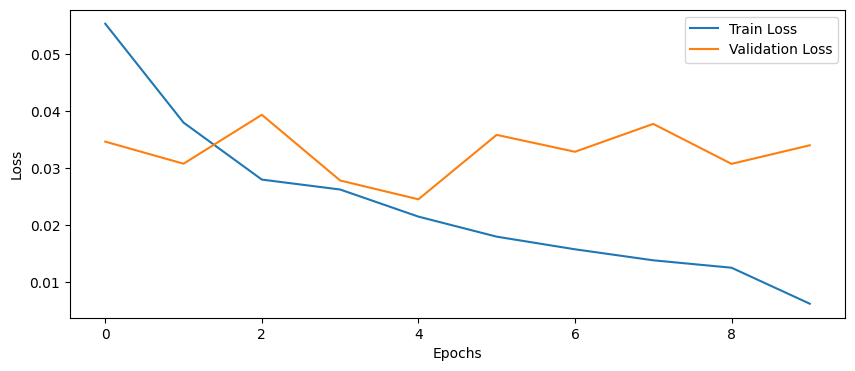

In [12]:
fig = vgg_fine_tuned_model.plot_losses()

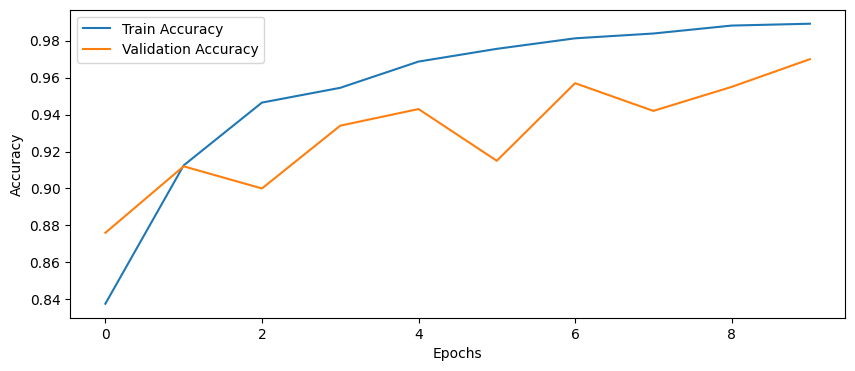

In [13]:
fig = vgg_fine_tuned_model.plot_accuracy()

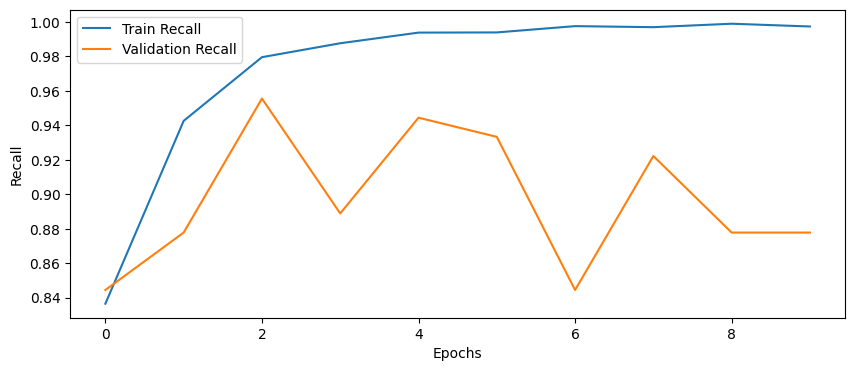

In [14]:
fig = vgg_fine_tuned_model.plot_recall()

In [15]:
### Train VGG 16 Feature Extraction Model

In [16]:
torch.manual_seed(13)

loss_fn = FocalLoss(alpha=0.5, gamma=2)
optimizer = optim.AdamW(
    vgg_feature_extract.classifier[6].parameters(), lr=1e-4, weight_decay=1e-4
)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

vgg_feature_extract_model = ClassificationModelBuilding(
    vgg_feature_extract,
    loss_fn,
    optimizer,
    vgg_train_loader,
    vgg_val_loader,
    scheduler,
    early_stopping_patience=5,
)
vgg_feature_extract_model.fit(epochs=20)

Early stopping occurred at epoch 17
Restoring model to best validation loss: 0.05671258026268333

--- Training Completed ---
Final training loss = 0.0655  |  Final validation loss = 0.0579
Final training accuracy = 0.7886  |  Final validation accuracy = 0.8440
Final training recall = 0.7418  |  Final validation recall = 0.6889
Final training precision = 0.8122  |  Final validation precision = 0.3263
Final training F1 = 0.7754  |  Final validation F1 = 0.4429
Final training AUC = 0.8725  |  Final validation AUC = 0.8714



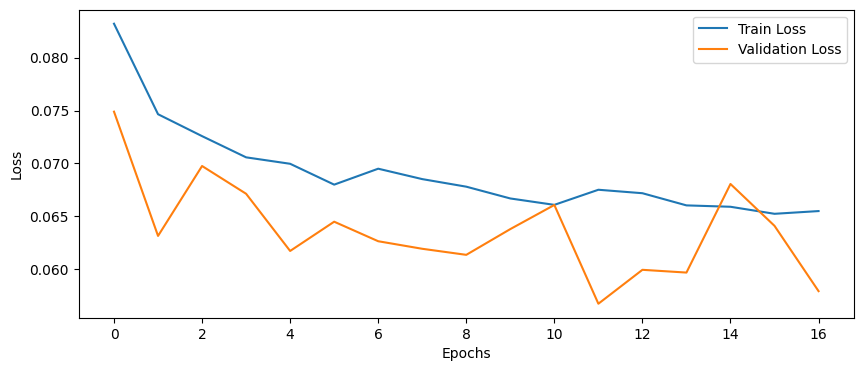

In [17]:
fig = vgg_feature_extract_model.plot_losses()

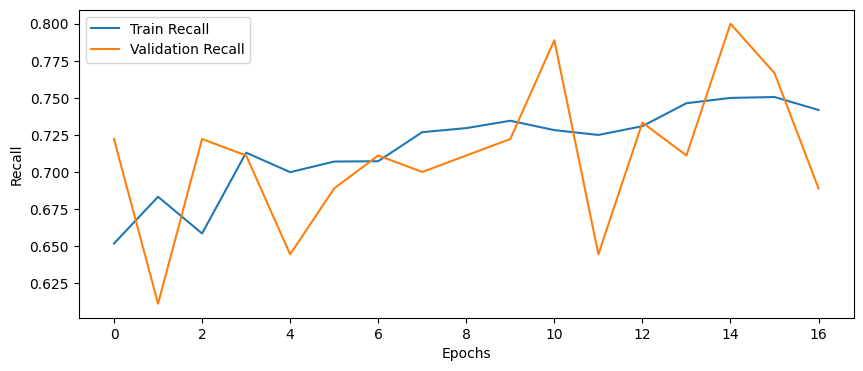

In [18]:
fig = vgg_feature_extract_model.plot_recall()

In [19]:
### Train Inception V3 Fine-tuned Model

In [20]:
torch.manual_seed(13)

loss_fn = FocalLoss(alpha=0.5, gamma=2)
optimizer = optim.AdamW(incep_fine_tune.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

incep_fine_tuned_model = ClassificationModelBuilding(
    incep_fine_tune,
    loss_fn,
    optimizer,
    incep_train_loader,
    incep_val_loader,
    scheduler,
    early_stopping_patience=5,
)
incep_fine_tuned_model.fit(epochs=20)

Early stopping occurred at epoch 9
Restoring model to best validation loss: 0.019810337003036693

--- Training Completed ---
Final training loss = 0.0035  |  Final validation loss = 0.0248
Final training accuracy = 0.9967  |  Final validation accuracy = 0.9770
Final training recall = 0.9994  |  Final validation recall = 0.8889
Final training precision = 0.9940  |  Final validation precision = 0.8602
Final training F1 = 0.9967  |  Final validation F1 = 0.8743
Final training AUC = 0.9999  |  Final validation AUC = 0.9708



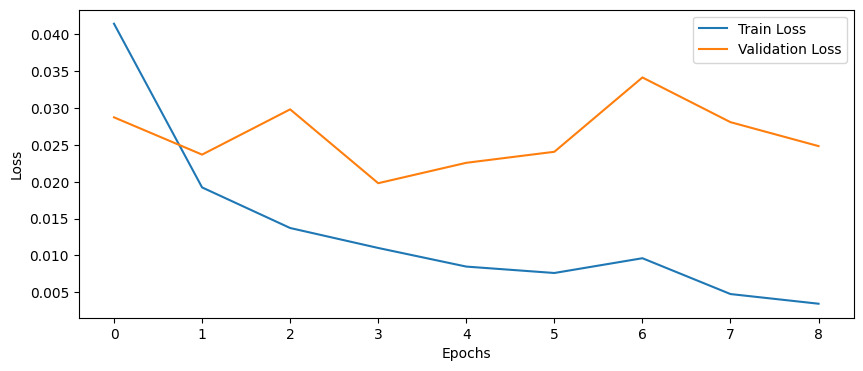

In [21]:
fig = incep_fine_tuned_model.plot_losses()

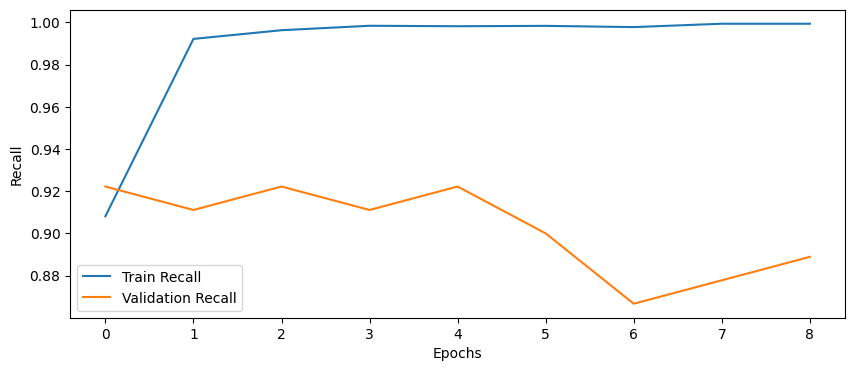

In [22]:
fig = incep_fine_tuned_model.plot_recall()

In [23]:
### Train Inception V3 Feature Extraction Model

In [24]:
torch.manual_seed(13)

loss_fn = FocalLoss(alpha=0.5, gamma=2)
optimizer = optim.AdamW(
    incep_feature_extract.fc.parameters(), lr=1e-4, weight_decay=1e-4
)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

incep_feature_extract_model = ClassificationModelBuilding(
    incep_feature_extract,
    loss_fn,
    optimizer,
    incep_train_loader,
    incep_val_loader,
    scheduler,
    early_stopping_patience=5,
)
incep_feature_extract_model.fit(epochs=20)

Early stopping occurred at epoch 10
Restoring model to best validation loss: 0.06594479759223759

--- Training Completed ---
Final training loss = 0.0709  |  Final validation loss = 0.0680
Final training accuracy = 0.7567  |  Final validation accuracy = 0.7650
Final training recall = 0.7408  |  Final validation recall = 0.7222
Final training precision = 0.7639  |  Final validation precision = 0.2364
Final training F1 = 0.7522  |  Final validation F1 = 0.3562
Final training AUC = 0.8358  |  Final validation AUC = 0.8123



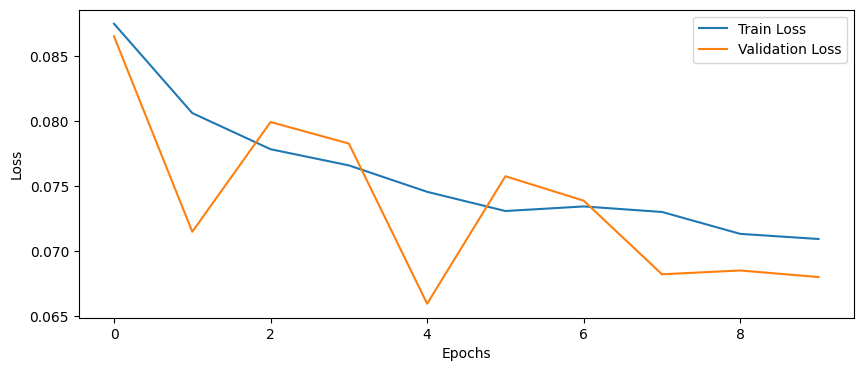

In [25]:
fig = incep_feature_extract_model.plot_losses()

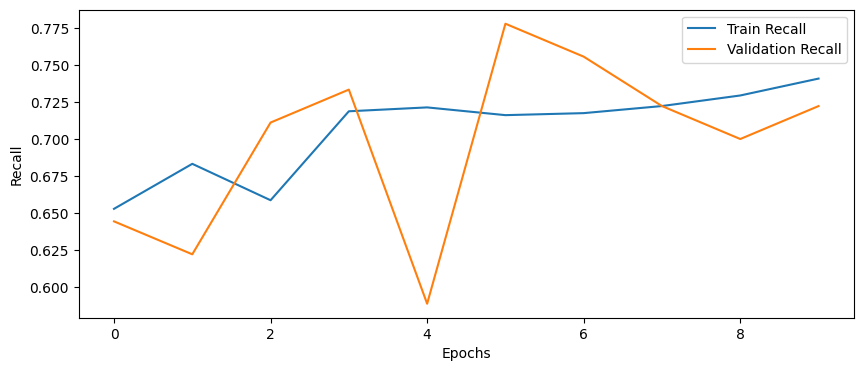

In [26]:
fig = incep_feature_extract_model.plot_recall()

### Random Search for Hyperparameter Tuning

In [27]:
random.seed(23)
# Number of random trials
num_trials = 10

random_search_vals = []

for i in range(num_trials):
    # Sample learning rate
    log_lr = random.uniform(-5, -3)
    lr = 10**log_lr

    # Sample alpha
    alpha = random.uniform(0.25, 0.75)

    # Sample gamma
    gamma = random.uniform(1.0, 4.0)

    print(f"Sampled LR: {lr:.6f}, alpha: {alpha:.4f}, gamma: {gamma:.4f}")

    random_search_vals.append((lr, alpha, gamma))

# random_search_vals

Sampled LR: 0.000708, alpha: 0.7243, gamma: 3.6773
Sampled LR: 0.000015, alpha: 0.5460, gamma: 2.2712
Sampled LR: 0.000115, alpha: 0.3152, gamma: 1.5760
Sampled LR: 0.000077, alpha: 0.3605, gamma: 2.3651
Sampled LR: 0.000011, alpha: 0.2929, gamma: 3.1300
Sampled LR: 0.000070, alpha: 0.5063, gamma: 3.2026
Sampled LR: 0.000052, alpha: 0.2788, gamma: 3.3493
Sampled LR: 0.000151, alpha: 0.5790, gamma: 2.8630
Sampled LR: 0.000874, alpha: 0.4314, gamma: 3.2794
Sampled LR: 0.000055, alpha: 0.5360, gamma: 2.9816


In [28]:
def run_trials(base_model, random_search_vals, model_type="vgg", epochs=20):
    all_trial_results = []

    for i, trial in enumerate(random_search_vals):
        # Create a fresh copy of the model for each trial
        model = copy.deepcopy(base_model)

        lr, alpha, gamma = trial

        loss_fn = FocalLoss(alpha=alpha, gamma=gamma)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

        # Check whether the model is VGG or Inception
        if model_type == "vgg":
            train_loader = vgg_train_loader
            val_loader = vgg_val_loader
        else:
            train_loader = incep_train_loader
            val_loader = incep_val_loader

        model_trainer = ClassificationModelBuilding(
            model,
            loss_fn,
            optimizer,
            train_loader,
            val_loader,
            scheduler,
            early_stopping_patience=5,
        )
        model_trainer.fit(epochs=epochs)

        # Save plots
        trial_name = f"trial_{i+1}_lr_{lr:.5f}_alpha_{alpha:.2f}_gamma_{gamma:.2f}"

        result_path = f"{model_type}_results"
        os.makedirs(result_path, exist_ok=True)

        loss_path = os.path.join(result_path, f"{trial_name}_loss.png")
        recall_path = os.path.join(result_path, f"{trial_name}_recall.png")
        acc_path = os.path.join(result_path, f"{trial_name}_acc.png")

        model_trainer.plot_losses(save_path=loss_path)
        model_trainer.plot_recall(save_path=recall_path)
        model_trainer.plot_accuracy(save_path=acc_path)

        plt.close("all")

        trial_summary = {
            "trial_num": i + 1,
            "lr": lr,
            "alpha": alpha,
            "gamma": gamma,
            "best_val_loss": model_trainer.best_val_loss,
            "final_val_recall": model_trainer.val_recall[-1],
            "final_val_acc": model_trainer.val_acc[-1],
            "stopped_epochs": model_trainer.total_epochs,
        }
        all_trial_results.append(trial_summary)

    results_df = pd.DataFrame(all_trial_results)

    csv_path = os.path.join(result_path, f"{model_type}_all_trials_summary.csv")
    results_df.to_csv(csv_path, index=False)

In [29]:
# Train VGG 16 fine-tuned model using random search
run_trials(vgg_fine_tune, random_search_vals, model_type="vgg", epochs=20)

Early stopping occurred at epoch 7
Restoring model to best validation loss: 0.03779464459512383

--- Training Completed ---
Final training loss = 0.0393  |  Final validation loss = 0.0391
Final training accuracy = 0.5034  |  Final validation accuracy = 0.9100
Final training recall = 0.4577  |  Final validation recall = 0.0000
Final training precision = 0.5031  |  Final validation precision = 0.0000
Final training F1 = 0.4793  |  Final validation F1 = 0.0000
Final training AUC = 0.5010  |  Final validation AUC = 0.5000

Early stopping occurred at epoch 6
Restoring model to best validation loss: 0.048452867210220685

--- Training Completed ---
Final training loss = 0.0007  |  Final validation loss = 0.0570
Final training accuracy = 0.9991  |  Final validation accuracy = 0.9740
Final training recall = 1.0000  |  Final validation recall = 0.8667
Final training precision = 0.9982  |  Final validation precision = 0.8478
Final training F1 = 0.9991  |  Final validation F1 = 0.8571
Final traini

In [30]:
# Train Inception V3 fine-tuned model using random search
run_trials(incep_fine_tune, random_search_vals, model_type="incep", epochs=20)

Early stopping occurred at epoch 18
Restoring model to best validation loss: 0.010295762643238504

--- Training Completed ---
Final training loss = 0.0014  |  Final validation loss = 0.0156
Final training accuracy = 0.9957  |  Final validation accuracy = 0.9780
Final training recall = 0.9998  |  Final validation recall = 0.8778
Final training precision = 0.9916  |  Final validation precision = 0.8778
Final training F1 = 0.9957  |  Final validation F1 = 0.8778
Final training AUC = 0.9996  |  Final validation AUC = 0.9833

Early stopping occurred at epoch 6
Restoring model to best validation loss: 0.029127304980733015

--- Training Completed ---
Final training loss = 0.0002  |  Final validation loss = 0.0394
Final training accuracy = 0.9996  |  Final validation accuracy = 0.9790
Final training recall = 1.0000  |  Final validation recall = 0.8667
Final training precision = 0.9992  |  Final validation precision = 0.8966
Final training F1 = 0.9996  |  Final validation F1 = 0.8814
Final trai

### Test Performance on Final Model

In [33]:
# Selected model
incep_final_model = copy.deepcopy(incep_fine_tune)

lr, alpha, gamma = random_search_vals[8]

loss_fn = FocalLoss(alpha=alpha, gamma=gamma)
optimizer = optim.AdamW(incep_final_model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

final_model = ClassificationModelBuilding(
    incep_final_model,
    loss_fn,
    optimizer,
    incep_train_loader,
    incep_val_loader,
    scheduler,
    early_stopping_patience=5,
)
final_model.fit(epochs=20)

Early stopping occurred at epoch 18
Restoring model to best validation loss: 0.006241177549782151

--- Training Completed ---
Final training loss = 0.0026  |  Final validation loss = 0.0071
Final training accuracy = 0.9892  |  Final validation accuracy = 0.9650
Final training recall = 0.9970  |  Final validation recall = 0.9222
Final training precision = 0.9816  |  Final validation precision = 0.7477
Final training F1 = 0.9892  |  Final validation F1 = 0.8259
Final training AUC = 0.9984  |  Final validation AUC = 0.9860



In [ ]:
test_root_dir = "../data/skin_cancer_test"
test_dataset = ImageFolder(root=test_root_dir, transform=incep_base_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

test_preds = []
test_labels = []
for x_batch, y_batch in test_loader:
    preds = final_model.predict(x_batch)
    test_preds.append(preds)
    test_labels.append(y_batch)

test_preds_np = torch.cat(test_preds).numpy()
test_labels_np = torch.cat(test_labels).numpy()

metrics = final_model._compute_metrics(test_labels_np, test_preds_np)

print(f"Accuracy is {metrics['accuracy']:.4f}")
print(f"Precision is {metrics['precision']:.4f}")
print(f"Recall is {metrics['recall']:.4f}")
print(f"F1 score is {metrics['F1']:.4f}")
print(f"AUC is {metrics['AUC']:.4f}")

Accuracy is 0.9630
Precision is 0.7524
Recall is 0.8778
F1 score is 0.8103
AUC is 0.9782
